# Time Series with Neural Networks

In [2]:
import warnings                         #'do not disturb' mode
warnings.filterwarnings('ignore')

import numpy as np                      # vectors and matrices
import pandas as pd                     # tables and data manipulations
import matplotlib.pyplot as plt         # plots
import seaborn as sns                   # more plots

%matplotlib inline 

In [3]:
ads = pd.read_csv('ads.csv',index_col = 0)

## MAPE error

In [42]:
## Accuracy Metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
ads.head()

,Ads
Time,
2017-09-13T00:00:00,80115
2017-09-13T01:00:00,79885
2017-09-13T02:00:00,89325
2017-09-13T03:00:00,101930
2017-09-13T04:00:00,121630


In [6]:
df = ads

In [7]:
len(df)

216

In [8]:
216-48     #we are planning prediction for next days , hence 48 hrs

168

In [10]:
train = df.iloc[:168]
test = df.iloc[168:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
Scaler.fit(train)

scaled_train = Scaler.transform(train)
scaled_test = Scaler.transform(test)

In [13]:
# pip install keras

Note: you may need to restart the kernel to use updated packages.


In [14]:
# pip install tensorflow

## Time Series generator

In [16]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# Define Generator

n_input = 24 #how many lagged time series point to predict the next point
n_feature = 1  #univariate time series

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size =1)

In [19]:
scaled_train[:25]

array([[0.05717736],
       [0.05476215],
       [0.15389058],
       [0.28625433],
       [0.49312192],
       [0.43898981],
       [0.33419091],
       [0.2953376 ],
       [0.3505723 ],
       [0.4353145 ],
       [0.59183031],
       [0.78074136],
       [0.87073401],
       [0.79854038],
       [0.78362911],
       [0.79208233],
       [0.73621758],
       [0.79827785],
       [0.93636459],
       [0.96151423],
       [0.68098288],
       [0.32789037],
       [0.23217473],
       [0.08243201],
       [0.05728237]])

In [20]:
len(generator)    #168 points - first 24 points(not predicted as we require 24 for prediction of 25th) = 144 

144

In [23]:
# Lets see the first batch (24 inputs and 1 predicted)

x,y = generator[0]

print(f'Given the {n_input} series point: \n{x.flatten()}')
print(f'Predicted the series point: \n {y}')

Given the 24 series point: 
[0.05717736 0.05476215 0.15389058 0.28625433 0.49312192 0.43898981
 0.33419091 0.2953376  0.3505723  0.4353145  0.59183031 0.78074136
 0.87073401 0.79854038 0.78362911 0.79208233 0.73621758 0.79827785
 0.93636459 0.96151423 0.68098288 0.32789037 0.23217473 0.08243201]
Predicted the series point: 
 [[0.05728237]]


In [24]:
from keras.models import Sequential
from keras.layers import Dense , LSTM

## Model

In [27]:
# Define the model

model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(n_input, n_feature)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                2700      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit_generator(generator, epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
144/144 [==============================] - 2s 16ms/step - loss: 0.1300
Epoch 2/50
144/144 [==============================] - 3s 18ms/step - loss: 0.0748
Epoch 3/50
144/144 [==============================] - 3s 24ms/step - loss: 0.0542: 0s 
Epoch 4/50
144/144 [==============================] - 3s 23ms/step - loss: 0.0360: 2s - loss - ETA: 1s - loss: -
Epoch 5/50
144/144 [==============================] - 4s 26ms/step - loss: 0.0242
Epoch 6/50
144/144 [==============================] - ETA: 0s - loss: 0.0206- - ETA: 0s  - 3s 24ms/step - loss: 0.0206
Epoch 7/50
144/144 [==============================] - 3s 24ms/step - loss: 0.0265: 1s - loss: 0.01 - ETA: 1s - loss:  - ETA: 1s - loss: 0. - ETA: 
Epoch 8/50
144/144 [==============================] - 4s 30ms/step - loss: 0.0215: 1s 
Epoch 9/50
144/144 [==============================] - 4s 26ms/step - loss: 0.0178
Epoch 10/50
144/144 [======================

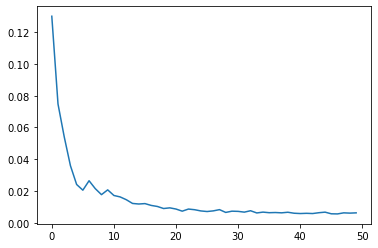

In [32]:
loss_per_epoch = model.history.history['loss']

plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_feature))


for i in range(len(test)):
    
#     get predictios 1 time stamp ahead ([0] is for grabbing just the number instead of array)
    current_pred = model.predict(current_batch)[0]
    
#     store predictions
    test_predictions.append(current_pred)
    
#     update batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [34]:
test_predictions

[array([0.01319247], dtype=float32),
 array([0.02459866], dtype=float32),
 array([0.07659328], dtype=float32),
 array([0.17054978], dtype=float32),
 array([0.25310194], dtype=float32),
 array([0.29224816], dtype=float32),
 array([0.30712706], dtype=float32),
 array([0.32331437], dtype=float32),
 array([0.36208284], dtype=float32),
 array([0.42990738], dtype=float32),
 array([0.5074854], dtype=float32),
 array([0.57577443], dtype=float32),
 array([0.62684965], dtype=float32),
 array([0.6622022], dtype=float32),
 array([0.6931706], dtype=float32),
 array([0.72614145], dtype=float32),
 array([0.7660582], dtype=float32),
 array([0.80751294], dtype=float32),
 array([0.8331435], dtype=float32),
 array([0.81652135], dtype=float32),
 array([0.6217107], dtype=float32),
 array([0.38572186], dtype=float32),
 array([0.20993552], dtype=float32),
 array([0.11577234], dtype=float32),
 array([0.08573788], dtype=float32),
 array([0.09636739], dtype=float32),
 array([0.12570387], dtype=float32),
 array(

In [36]:
true_predictions = Scaler.inverse_transform(test_predictions)

In [37]:
test['predictions'] = true_predictions

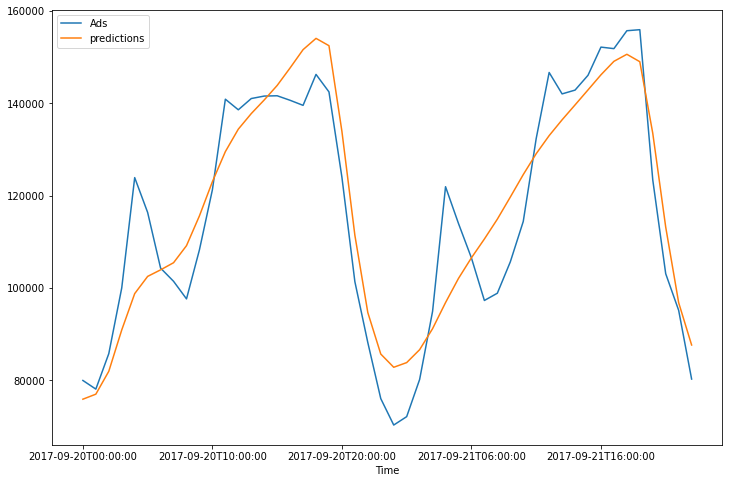

In [38]:
test.plot(figsize=(12,8))

In [39]:
test

,Ads,predictions
Time,,
2017-09-20T00:00:00,79980,75926.319379
2017-09-20T01:00:00,78110,77012.530209
2017-09-20T02:00:00,85785,81963.978039
2017-09-20T03:00:00,100010,90911.455562
2017-09-20T04:00:00,123880,98772.898215
2017-09-20T05:00:00,116335,102500.792243
2017-09-20T06:00:00,104290,103917.709782
2017-09-20T07:00:00,101440,105459.227334
2017-09-20T08:00:00,97635,109151.148759


In [43]:
error = mean_absolute_percentage_error(test.Ads,test.predictions)
error

7.241697298001816

In [ ]:
# Increase the nodes in LSTM for more accuracy and better mape 

In [ ]:
# Define the model

# model = Sequential()
# model.add(LSTM(30, activation='relu', input_shape=(n_input, n_feature)))
# model.add(Dense(1))
# model.compile(optimizer = 'adam', loss = 'mse')